In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn
#plt.rcParams['figure.figsize']=[9,9]

# Expected Risk Minimization

In [34]:
features=4
samples=10000

#properties to estimate guassian distribution
#mean vector- given
mean=np.zeros((features,2))

mean[:,0]=[-1,-1,-1,-1]
mean[:,1]=[1,1,1,1]

#covariance matrix- given
cov=np.zeros((features,features,2))

cov[:,:,0]=[[2,-0.5,0.3,0],
            [-0.5,1,-0.5,0],
            [0.3,-0.5,1,0],
            [0,0,0,2]]

cov[:,:,1]=[[1,0.3,-0.2,0],
            [0.3,2,0.3,0],
            [-0.2,0.3,1,0],
            [0,0,0,3]]

In [35]:
prior=[0.7,0.3]
label=np.zeros((samples,1))
label[:,0]=(np.random.uniform(0,1,samples) >= prior[0]).astype(int)
NC=[int(sum(label==0)),int(sum(label==1))]


In [36]:
def create_data(mean,cov):
    X=np.zeros((features,samples))

    for i in range(samples):
        if label[i,0]==0:
            X[:,i] =np.random.multivariate_normal(mean[:,0],cov[:,:,0],1)
        else:
            X[:,i] =np.random.multivariate_normal(mean[:,1],cov[:,:,1],1)
    return X

X=create_data(mean,cov)

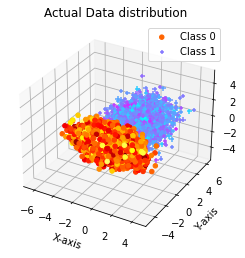

In [37]:
def plot_data_dist(X):
    x0 = [i for i in range(label.shape[0]) if (label[i,0] == 0)]
    x1 = [i for i in range(label.shape[0]) if (label[i,0] == 1 )]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x=X[0,x0]
    y=X[1,x0]
    z=X[2,x0]
    c=X[3,x0]

    X1=X[0,x1]
    y1=X[1,x1]
    z1=X[2,x1]
    c1=X[3,x1]
    ax.scatter(x, y, z,c=c, cmap=plt.hot(),alpha=1,marker='o')
    ax.scatter(X1, y1, z1,c=c1, cmap=plt.cool(),alpha=1,marker='+')

    plt.title("Actual Data distribution")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    ax.legend(['Class 0','Class 1'])
    plt.show()
    
plot_data_dist(X)

In [38]:
def compute_discriminant_score(X,mean,cov):
    log_pdf1=np.log(mvn.pdf(X.T,mean =mean[:,1], cov=cov[:,:,1]))
    log_pdf0=np.log(mvn.pdf(X.T,mean =mean[:,0], cov=cov[:,:,0]))
    disc_score= log_pdf1-log_pdf0
    return disc_score

def compute_gamma(disc_score,samples):
    ds=np.sort(disc_score)
    return [np.log(ds[i]) for i in range(samples) if ds[i] >= 0]

disc_score=compute_discriminant_score(X,mean,cov)
gamma=compute_gamma(disc_score,samples)


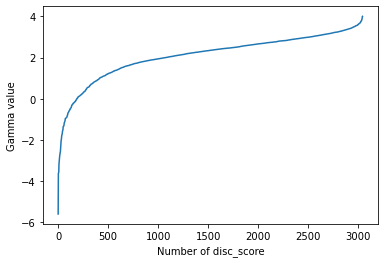

In [39]:
plt.plot(gamma)
plt.xlabel("Number of disc_score")
plt.ylabel("Gamma value")
plt.show()

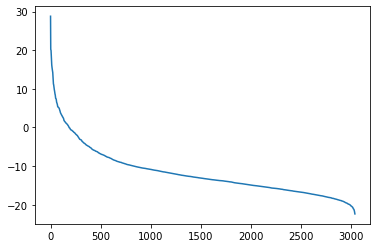

In [66]:
def compute_gamma_mid_point(gamma):
    mid_gamma= []
    for i in range(len(gamma)-1):
        avg=(gamma[i]-gamma[i+1])/2.0
        mid_gamma.append(gamma[0] * gamma[i] + avg *(gamma[-1]))
    return mid_gamma

mid_gamma=compute_gamma_mid_point(gamma)    
plt.plot(mid_gamma)

In [67]:
def count_positives(disc_score,gamma_val):
    p10=0;p11=0
    decision=(disc_score>= (gamma_val)).astype(int)

    for i in range(samples):
        if decision[i] ==1 and label[i] == 0:
            p10+=1
        elif decision [i] ==1 and label[i]==1:
            p11+=1
    return p10,p11
        
def compute_min_prob_error(mid_gamma,disc_score,label,NC,prior,samples):
    Perr=[]
    False_pos_rate=[]
    True_pos_rate=[]
    for j in range(len(mid_gamma)):
        p10,p11=count_positives(disc_score,mid_gamma[j])
        True_pos_rate.append((p11) / NC[1])
        False_pos_rate.append((p10) / NC[0])
        perr= (False_pos_rate[j] * prior[0]) + ( (1- True_pos_rate[j]) * prior[1])
        Perr.append(perr)
    return True_pos_rate, False_pos_rate,Perr

True_pos_rate, False_pos_rate,Prob_err=compute_min_prob_error(mid_gamma,disc_score,label,NC,prior,samples)


In [68]:
# minimum probability of error 
def estimate_MPE_prop(Prob_err,mid_gamma,disc_score,False_pos_rate, True_pos_rate):
    min_idx_gamma=np.argmin(Prob_err)
    optimal_gamma= mid_gamma[min_idx_gamma]
    min_perr= Prob_err[min_idx_gamma]

    min_decision= (disc_score >=optimal_gamma) 
    min_False_pos_rate= False_pos_rate[min_idx_gamma]
    min_True_pos_rate= True_pos_rate[min_idx_gamma]
    
    return optimal_gamma,min_perr,min_decision,min_False_pos_rate,min_True_pos_rate

optimal_gamma,min_perr,min_decision,min_False_pos_rate,min_True_pos_rate =estimate_MPE_prop(Prob_err,mid_gamma,disc_score,False_pos_rate, True_pos_rate)

#Ideal minimum probability of error 
ideal_fp, ideal_tp= count_positives(disc_score, np.log(prior[0]/ prior[1]))

ideal_decision= (disc_score >= np.log(prior[0]/ prior[1]) )
ideal_fpr=ideal_fp/NC[0]
ideal_tpr=ideal_tp/NC[1]

ideal_err= ideal_fpr*prior[0] + (1-ideal_tpr) * prior[1]


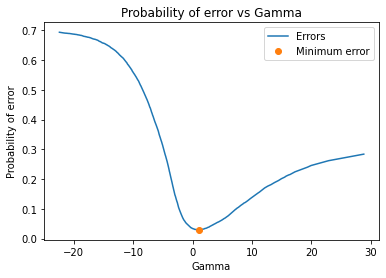

In [72]:
plt.plot( mid_gamma, Prob_err)
plt.plot(optimal_gamma,min_perr, 'o')
plt.xlabel('Gamma')
plt.ylabel('Probability of error')
plt.legend(['Errors','Minimum error'])
plt.title('Probability of error vs Gamma')
plt.show()

 Ideal error : 2.986%, Ideal Gamma : 2.333 
 Min error : 2.890%, Calc. Gamma : 3.198 


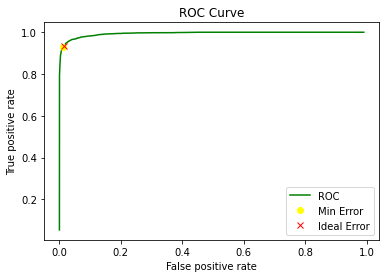

Min P(e) = 0.029
TPR = 0.93
FPR = 0.01


In [70]:
plt.plot(False_pos_rate,True_pos_rate,color='green')
plt.plot(min_False_pos_rate, min_True_pos_rate,'o',color='yellow')
plt.plot(ideal_fpr,ideal_tpr,'x',color='red')

print(f' Ideal error : {ideal_err*100 :.3f}%, Ideal Gamma : {prior[0]/ prior[1] :.3f} ')
print(f' Min error : {min_perr*100 :.3f}%, Calc. Gamma : {np.exp(optimal_gamma) :.3f} ' )

plt.legend(['ROC','Min Error','Ideal Error'])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.show()

print('Min P(e) = ' + str(round(Prob_err[np.argmin(Prob_err)],3)) + '\n'
 +'TPR = '+ str(round(True_pos_rate[np.argmin(Prob_err)],2)) + '\n' 
 +'FPR = '+ str(round(False_pos_rate[np.argmin(Prob_err)],2)))


# Naive Bayes

In [44]:
#Naive bayes
cov_NB=np.zeros((features,features,2))
cov_NB[:,:,0]=[[2,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,2]]

cov_NB[:,:,1]=[[1,0,0,0],
              [0,2,0,0],
              [0,0,1,0],
              [0,0,0,3]]


In [45]:
Xnb=create_data(mean,cov_NB)

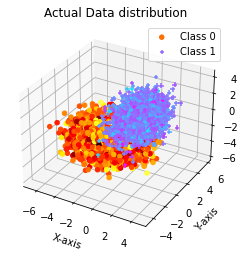

In [46]:
plot_data_dist(Xnb)

In [74]:
#prob of error is computed
disc_score_nb= compute_discriminant_score(Xnb, mean, cov_NB)
gamma_nb= compute_gamma(disc_score_nb,samples)
mid_gamma_nb=compute_gamma_mid_point(gamma_nb)

TPR_nb,FPR_nb,Perr_nb=compute_min_prob_error(mid_gamma_nb,disc_score_nb,label,NC,prior,samples)

In [75]:
#estimate min prob error parameters
optimal_gamma_nb,min_perr_nb,min_decision_nb,min_FPR_nb,min_TPR_nb=estimate_MPE_prop(Perr_nb,mid_gamma_nb,disc_score_nb,FPR_nb,TPR_nb)

In [76]:
#ideal parameters
ideal_fp_nb, ideal_tp_nb= count_positives(disc_score_nb, np.log(prior[0]/ prior[1]))

ideal_decision_nb= (disc_score_nb >= np.log(prior[0]/ prior[1]) )

ideal_fpr_nb=ideal_fp_nb/NC[0]
ideal_tpr_nb=ideal_tp_nb/NC[1]

ideal_err_nb= ideal_fpr_nb*prior[0] + (1-ideal_tpr_nb) * prior[1]

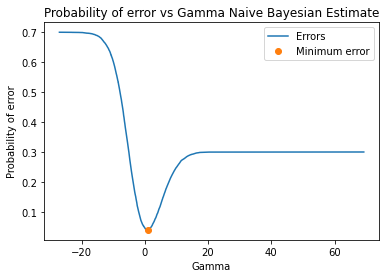

In [77]:
plt.plot( mid_gamma_nb, Perr_nb)
plt.plot(optimal_gamma_nb,min_perr_nb, 'o')
plt.xlabel('Gamma')
plt.ylabel('Probability of error')
plt.legend(['Errors','Minimum error'])
plt.title('Probability of error vs Gamma Naive Bayesian Estimate')
plt.show()

 Ideal error : 0.0399, Gamma : 2.33 
 Min error : 0.0397, Calc. Gamma : 2.78 


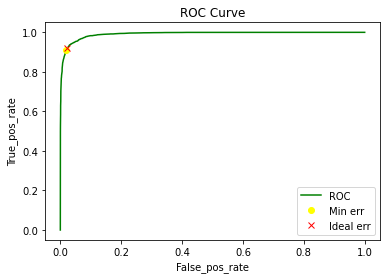

Min P(e) = 0.04
TPR = 0.91
FPR = 0.02


In [78]:
#plotting roc
plt.plot(FPR_nb,TPR_nb,color='green')
plt.plot(min_FPR_nb, min_TPR_nb,'o',color='yellow')
plt.plot(ideal_fpr_nb,ideal_tpr_nb,'x',color='red')

print(f' Ideal error : {ideal_err_nb :.4f}, Gamma : {prior[0]/ prior[1] :.2f} ')
print(f' Min error : {min_perr_nb :.4f}, Calc. Gamma : {np.exp(optimal_gamma_nb) :.2f} ' )

plt.legend(['ROC', 'Min err', 'Ideal err'])
plt.xlabel('False_pos_rate')
plt.ylabel('True_pos_rate')
plt.title('ROC Curve')
plt.show()

print('Min P(e) = ' + str(round(Perr_nb[np.argmin(Perr_nb)],3)) + '\n'
 +'TPR = '+ str(round(TPR_nb[np.argmin(Perr_nb)],2)) + '\n' 
 +'FPR = '+ str(round(FPR_nb[np.argmin(Perr_nb)],2)))


# Fisher Linear Discriminant Analysis (LDA)


In [51]:
m=(mean[:,0] - mean[:,1])
S_between= np.matmul(m, m.T)
S_between #1,1
S_within=(cov[:,:,0] + cov[:,:,1])
S_within #4,4

# Calculation of W_lda
a,b = np.linalg.eig(np.dot(np.linalg.inv(S_within),S_between))
w_LDA = np.array(b[:,np.argmax(a)])  #col of highest eigen value

transposed_wlda=(w_LDA).reshape(1,4)

In [52]:
# Calculation of Projection vector
y0 = np.zeros((NC[0],1))
y1 = np.zeros((NC[1],1))

Lx0 = [i for i in range(samples) if (label[i] == 0)]
Lx1 = [i for i in range(samples) if (label[i] == 1)]

y0[:,0] = np.dot(transposed_wlda, X[:,Lx0])
y1[:,0] = np.dot(transposed_wlda, X[:,Lx1])

y = np.sort(np.hstack((y0[:,0],y1[:,0])))


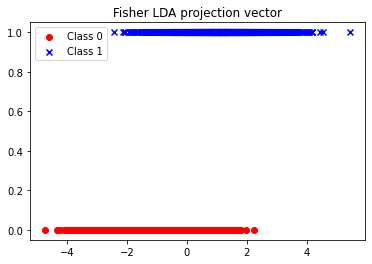

In [53]:
# Plot the Projection vector
plt.scatter(y0[:],np.zeros((NC[0])),marker='o',color="red")
plt.scatter(y1[:],np.ones((NC[1])),marker='x',color="blue")
plt.legend(['Class 0','Class 1'])
plt.title('Fisher LDA projection vector')
plt.show()

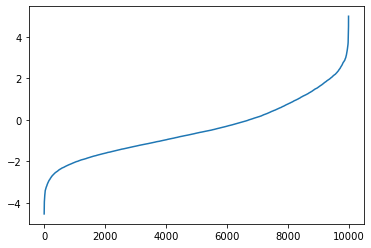

In [54]:
# Calculate Threshold values
tau = []
for i in range(len(y)-1):
    tau.append((y[i] + y[i+1])/2.0)
plt.plot(tau)

In [55]:
# Calculate decisions for varying thresholds
fpr = []
tpr = []
minPerr = []
i=0
for threshold in tau:
    #positive decision-->1
    x10 = list((y0[:,0] >= threshold).astype(int)).count(1)
    x11 = list((y1[:,0] >= threshold).astype(int)).count(1)
    
    fpr.append(float(x10)/NC[0])
    tpr.append(float(x11)/NC[1])
    perr= (fpr[i] * prior[0]) + ( (1- tpr[i]) * prior[1])
    minPerr.append(perr)
    i+=1


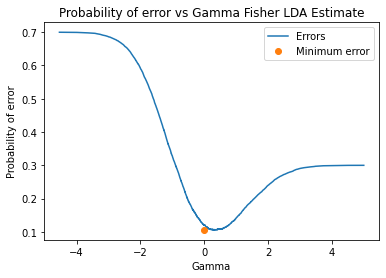

In [81]:
plt.plot(tau, minPerr)
plt.plot(minPerr[np.argmin(minPerr)], 'o')
plt.xlabel('Gamma')
plt.ylabel('Probability of error')
plt.legend(['Errors','Minimum error'])
plt.title('Probability of error vs Gamma Fisher LDA Estimate')
plt.show()

Min_P(e) = 0.1058
TPR = 0.77
FPR = 0.05
threshold = 0.31


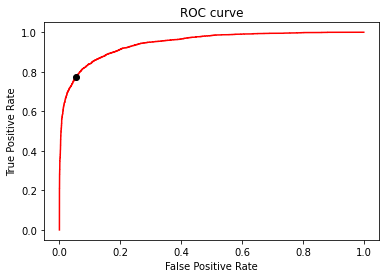

In [82]:
# Plot the ROC curve
plt.plot(fpr,tpr,color = 'red' )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(fpr[np.argmin(minPerr)],tpr[np.argmin(minPerr)],'o',color = 'black')
plt.title("ROC curve")


print('Min_P(e) = ' + str(round(minPerr[np.argmin(minPerr)],4)) + '\n'
 +'TPR = '+ str(round(tpr[np.argmin(minPerr)],2)) + '\n' 
 +'FPR = '+ str(round(fpr[np.argmin(minPerr)],2)) + '\n' 
 +'threshold = '+ str(round(tau[np.argmin(minPerr)],2)))

plt.show()